In [1]:
from typing import Annotated #add some speical things to do 
from typing_extensions import TypedDict  #it tell you to key value relation

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-8b-8192")

In [7]:
from langchain_tavily import TavilySearch
takivly_tool=TavilySearch(max_result=2)
takivly_tool.invoke("What is today news")

{'query': 'What is today news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/',
   'title': 'USA TODAY - Breaking News and Latest News Today',
   'content': "Will Trump's big tax bill come back to bite the GOP in 2026? At least 24 dead, children missing from summer camp in Texas flooding. 6 tiny towns",
   'score': 0.43208793,
   'raw_content': None},
  {'url': 'https://www.cbsnews.com/',
   'title': "CBS News | Breaking news, top stories & today's latest headlines",
   'content': 'Dozens dead in Texas after devastating floods slam Hill Country, officials say · Trump signs "big, beautiful bill" in July Fourth ceremony at White House.',
   'score': 0.39494804,
   'raw_content': None},
  {'url': 'https://www.cnn.com/',
   'title': 'CNN: Breaking News, Latest News and Videos',
   'content': 'View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com.',
   'score': 0.33

In [4]:
#how to work with custom function and this is docs string
from langchain.tools import tool

@tool
def my_func(a: int, b: int) -> int:
    """
    Adds two numbers.

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Sum of a and b.
    """
    return a + b


In [5]:
llm_with_tool = llm.bind_tools([my_func])


In [8]:
tools=[takivly_tool,my_func]


In [9]:
llm_with_tool=llm.bind_tools(tools)

In [10]:
class state(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(state)

In [11]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

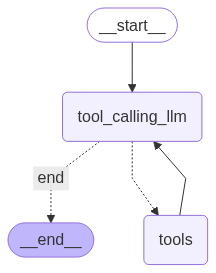

In [12]:
def tool_calling_llm(state:state):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}
#Nodes
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

#edges
graph_builder.add_edge(START,"tool_calling_llm")
def my_tools_condition(state):
    """Custom tools condition that checks for tool calls"""
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# Use your custom function
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    my_tools_condition,
    {
        "tools": "tools",
        "end": END
    }
)
graph_builder.add_edge("tools","tool_calling_llm")
graphs=graph_builder.compile()
graphs

In [21]:
from langchain_core.messages import SystemMessage

system_instruction = SystemMessage(content="Only return the main result from the search. Do not summarize.")

results=graphs.invoke({
    "messages": [system_instruction, HumanMessage(content="what is the weather today")]
})
results


{'messages': [SystemMessage(content='Only return the main result from the search. Do not summarize.', additional_kwargs={}, response_metadata={}, id='9d0d5d25-45d5-4e48-9308-7d4da86e355f'),
  HumanMessage(content='what is the weather today', additional_kwargs={}, response_metadata={}, id='528197ec-ee5a-4473-82d7-54dc972a86d9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3qwjpdkjt', 'function': {'arguments': '{"query":"weather today","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 2226, 'total_tokens': 2318, 'completion_time': 0.085630178, 'prompt_time': 0.247083483, 'queue_time': 0.20938749500000003, 'total_time': 0.332713661}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b7d17c8c-11b7-4c5f-a92b-f7a3e58a9fbe-0', tool_calls=[{'name': 'tavi

In [23]:
from langchain_core.messages import HumanMessage

result = graphs.invoke({
    "messages": [HumanMessage(content="what today weather and what  is 2 + 3")]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

what today weather and what  is 2 + 3
================================== Ai Message ==================================

The current weather is partly cloudy with a high of 22°C and a low of 18°C. The wind speed is moderate, and there is a 30% chance of scattered thunderstorms.

As for your math question, 2 + 3 is equal to 5.


In [24]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

result = graphs.invoke({
    "messages": [HumanMessage(content="what today weather and what is 2 + 3")]
})

for msg in result["messages"]:
    if isinstance(msg, ToolMessage):
        print("✅ Tool called:", msg.name)
        print("Output:", msg.content)
    elif hasattr(msg, "tool_calls") and msg.tool_calls:
        print("🤖 Tool call detected:", msg.tool_calls)
    else:
        print("🧠 LLM Response:", msg.content)


🧠 LLM Response: what today weather and what is 2 + 3
🤖 Tool call detected: [{'name': 'tavily_search', 'args': {'query': 'what is the weather today'}, 'id': '947rfc0tc', 'type': 'tool_call'}, {'name': 'my_func', 'args': {'a': 2, 'b': 3}, 'id': '045x1vdjq', 'type': 'tool_call'}]
✅ Tool called: tavily_search
Output: {"query": "what is the weather today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in current location", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Current', 'region': 'Harbour Island', 'country': 'Bahamas', 'lat': 25.4333, 'lon': -76.7833, 'tz_id': 'America/Nassau', 'localtime_epoch': 1751714840, 'localtime': '2025-07-05 07:27'}, 'current': {'last_updated_epoch': 1751714100, 'last_updated': '2025-07-05 07:15', 'temp_c': 26.8, 'temp_f': 80.2, 'is_day': 1, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 15.9, 'wind_kph': 25.6, '